In [1]:
pip install arff

import pandas as pd
import arff
import requests
from io import StringIO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator


# ***Data import***



url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff'
response = requests.get(url)
arff_str = response.text
attributes_str, data_str = arff_str.split('@data', 1)

# 解析属性定义部分，提取列名
attribute_lines = [line.strip() for line in attributes_str.splitlines() if line.startswith('@attribute')]
column_names = ['qa', 'pre_screen', 'ma_0_5', 'ma_0_6', 'ma_0_7', 'ma_0_8', 'ma_0_9', 'ma_1', 'exudate_0_3', 'exudate_0_4', 'exudate_0_5', 'exudate_0_6', 'exudate_0_7', 'exudate_0_8', 'exudate_0_9', 'exudate_1', 'eucli_of_mac_optic_disc', 'diam_optic_disc', 'am_fm_class', 'class_label']
# 使用 pandas 从数据部分创建 DataFrame
data_lines = [line.strip() for line in data_str.splitlines() if line.strip()]
data = [line.split(',') for line in data_lines]
df = pd.DataFrame(data, columns=column_names)
df=df.astype("float")

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# ***Visualization***

df.describe()

df.hist(figsize=(12,10), bins=20)

df.plot(kind= 'box' , subplots=True, layout=(4,5), sharex=False, sharey=False, figsize=(10,8))

df.corr()

# we want to see the correlation between pairs of variables
# a basis for feature selection
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr()
ax = sns.heatmap(corr, annot = True, cmap="YlGnBu")

plt.setp(ax.axes.get_xticklabels(), rotation=45)
plt.rcParams['figure.figsize']=(50,40)
plt.title('Correlation Matrix for Diabetic retinopathy Data')

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

feature1 = df['ma_0_8'].values
feature3 = df['exudate_0_5'].values 
feature2 = df['diam_optic_disc'].values

c=np.where(df['class_label'] == 1, 'red', 'blue')

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1, feature2, feature3, c=c)
ax.set_xlabel('ma_0_8')
ax.set_ylabel('exudate_0_5')
ax.set_zlabel('diam_optic_disc')

plt.show()

# ***Split***

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# ***Normalization***

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

fnor = ['ma_0_5', 'ma_0_6', 'ma_0_7', 'ma_0_8', 'ma_0_9', 'ma_1', 'exudate_0_3', 'exudate_0_4', 'exudate_0_5', 'exudate_0_6', 'exudate_0_7', 'exudate_0_8', 'exudate_0_9', 'exudate_1', 'eucli_of_mac_optic_disc', 'diam_optic_disc']

scaler = MinMaxScaler()
# 对指定的特征进行归一化
X_train[fnor] = scaler.fit_transform(X_train[fnor])
X_test[fnor] = scaler.transform(X_test[fnor])
# 显示归一化后的数据

# ***Feature selection***

from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=self.test_size, 
                                 random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1 

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X.iloc[:, list(self.indices_)]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        indices = list(indices)
        self.estimator.fit(X_train.iloc[:, indices], y_train)
        y_pred = self.estimator.predict(X_test.iloc[:, indices])
        score = self.scoring(y_test, y_pred)
        return score


%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
N = np.sqrt(X_train.shape[0] + 1)
N = int(N)
knn = KNeighborsClassifier(n_neighbors=N)
#svc = SVC(C=10, kernel="poly", degree=3)
# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train, y_train)



  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4970 sha256=f2147effb908d2ad75a6580df01483eb9a8ddea5d6f020b94637b7c8fa6c4b41
  Stored in directory: /Users/xuyulong/Library/Caches/pip/wheels/5e/d6/66/a25682c020fb563800fea1a06de58e4684243efd68cb83db83
Successfully built arff
Note: you may need to restart the kernel to use updated packages.


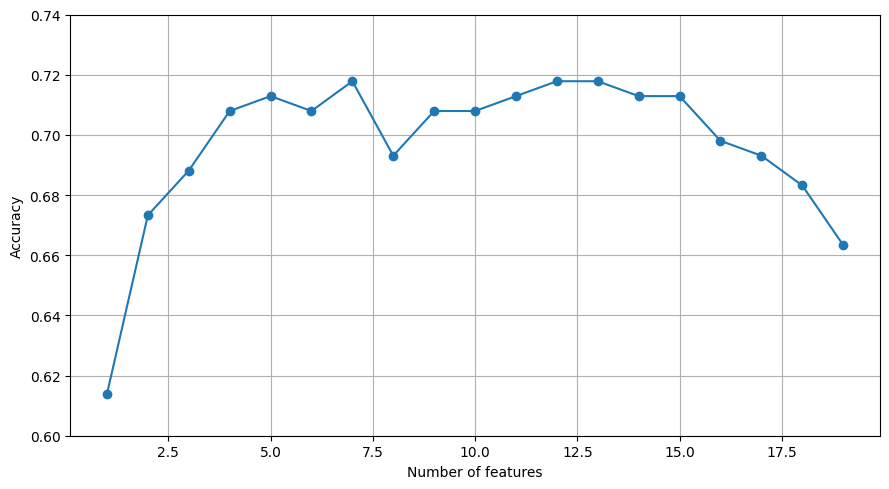

In [ ]:
# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]
fig = plt.figure(figsize=(9,5))
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.60, 0.74])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 17),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 17),
 (0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 13, 17),
 (1, 2, 3, 4, 6, 7, 8, 9, 11, 13, 17),
 (1, 2, 3, 6, 7, 8, 9, 11, 13, 17),
 (1, 2, 3, 6, 7, 8, 9, 11, 17),
 (1, 2, 3, 6, 7, 8, 9, 11),
 (1, 2, 3, 7, 8, 9, 11),
 (1, 2, 3, 7, 9, 11),
 (1, 2, 7, 9, 11),
 (1, 2, 7, 9),
 (1, 2, 7),
 (2, 7),
 (2,)]

In [ ]:
k7=list(sbs.subsets_[12])
k7

[1, 2, 3, 7, 8, 9, 11]

In [ ]:
feature_labels = df.columns[0:-1]
feature_labels[k7]

Index(['pre_screen', 'ma_0_5', 'ma_0_6', 'ma_1', 'exudate_0_3', 'exudate_0_4',
       'exudate_0_6'],
      dtype='object')

In [ ]:
X_train = X_train[feature_labels[k7]]
X_test = X_test[feature_labels[k7]]

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

class TSNE:
    def __init__(self, n_components=2, perplexity=30, early_exaggeration=4.0, learning_rate=100, n_iter=1000, random_state=None):
        self.n_components = n_components
        self.perplexity = perplexity
        self.early_exaggeration = early_exaggeration
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X_train, y_train):
        # Compute pairwise distances between samples
        D = np.zeros((X_train.shape[0], X_train.shape[0]))
        for i in range(X_train.shape[0]):
            for j in range(i + 1, X_train.shape[0]):
                D[i, j] = np.linalg.norm(X_train[i, :] - X_train[j, :])
                D[j, i] = D[i, j]
                
        # Compute pairwise affinities using Student's t-distribution
        beta = 1.0 / (2.0 * self.perplexity)
        P = np.zeros((X_train.shape[0], X_train.shape[0]))
        for i in range(X_train.shape[0]):
            Di = D[i, np.concatenate((np.arange(0, i), np.arange(i + 1, X_train.shape[0])))]
            hi = np.exp(-beta * Di)
            P[i, np.concatenate((np.arange(0, i), np.arange(i + 1, X_train.shape[0])))] = hi / np.sum(hi)
                
        # Symmetrize the pairwise affinities
        P = 0.5 * (P + P.T)
        P = np.maximum(P, 1e-12)
        
        # Early exaggeration
        P *= self.early_exaggeration
        
        # Initialize Y using PCA
        pca = PCA(n_components=self.n_components, random_state=self.random_state)
        Y = pca.fit_transform(X_train)
        
        # Perform optimization using gradient descent
        eta = self.learning_rate
        for iteration in range(self.n_iter):
            # Compute pairwise distances between low-dimensional points
            D = np.zeros((Y.shape[0], Y.shape[0]))
            for i in range(Y.shape[0]):
                for j in range(i + 1, Y.shape[0]):
                    D[i, j] = np.linalg.norm(Y[i, :] - Y[j, :])
                    D[j, i] = D[i, j]
            
            # Compute the gradient
            Q = 1.0 / (1.0 + D ** 2)
            np.fill_diagonal(Q, 0)
            Q /= np.sum(Q)
            PQ = P - Q
            dY = np.zeros((Y.shape[0], self.n_components))
            for i in range(Y.shape[0]):
                dY[i, :] = np.sum(np.tile(PQ[:, i] * Q[:, i], (self.n_components, 1)).T * (Y[i, :] - Y), axis=0)
            
            # Update Y
            Y = Y - eta * dY
            
            # Clamp Y to prevent numerical instability


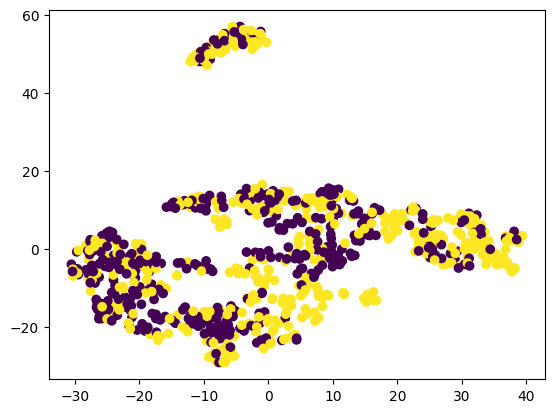

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 降维至2维
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train)

# 绘制t-SNE图形
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_train)
plt.show()


# ***SVM***

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# 创建SVC分类器
svc = SVC()

# 定义网格搜索的参数
param_grid = {
    'C': [0.1, 1, 10, 20],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3],  # 多项式核的次数
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

# 进行网格搜索
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best parameters found: ", grid_search.best_params_)

# 评估模型
y_pred = grid_search.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scal

In [ ]:
# 评估模型
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.5f' % clf.score(X_test, y_test))

Test accuracy: 0.73410


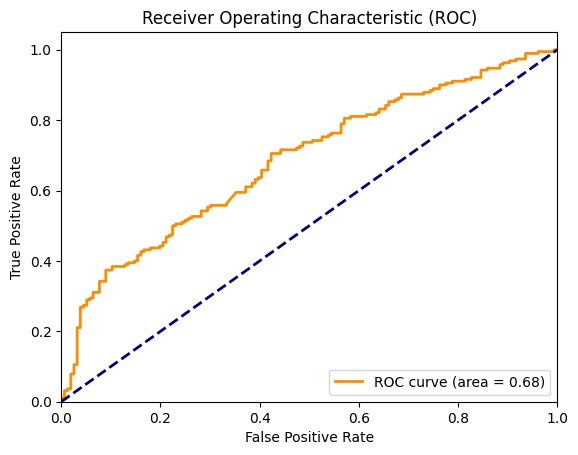

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Create and fit the model using the given parameters
model = SVC(C=1, kernel='rbf', gamma=0.0001, probability=True)
model.fit(X_train, y_train)

# Get the predicted probabilities for the test set
y_scores = model.predict_proba(X_test)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# ***evaluation***

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[129  27]
 [ 65 125]]


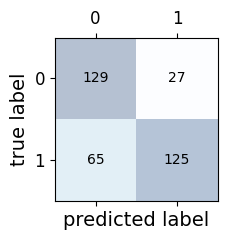

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.822
Recall: 0.658
F1: 0.731


# **bagging**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [ ]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier


In [ ]:
clf1 = GaussianNB()
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=0),
    random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['clf', clf1]])
pipe3 = Pipeline([['clf', clf3]])

# 5. Perform grid search for hyperparameter tuning
param_grid_pipe1 = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7]}
param_grid_bagging = {
    'n_estimators': [10, 30, 50],
    'max_samples': [0.6, 0.75, 0.9],
    'base_estimator__max_depth': [4, 6],
    'base_estimator__criterion': ['gini', 'entropy']
}
param_grid_pipe3 = {'clf__n_neighbors': [1, 3, 5], 'clf__p': [1, 2]}


In [ ]:
grid_pipe1 = GridSearchCV(pipe1, param_grid=param_grid_pipe1, cv=10, scoring='roc_auc')
grid_bagging = GridSearchCV(bagging_clf, param_grid=param_grid_bagging, cv=10, scoring='roc_auc')
grid_pipe3 = GridSearchCV(pipe3, param_grid=param_grid_pipe3, cv=10, scoring='roc_auc')

grid_pipe1.fit(X_train, y_train)
grid_bagging.fit(X_train, y_train)
grid_pipe3.fit(X_train, y_train)

print("Best parameters for Gaussian Naive Bayes:", grid_pipe1.best_params_)
print("Best parameters for Bagging Classifier:", grid_bagging.best_params_)
print("Best parameters for KNN:", grid_pipe3.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Best parameters for Gaussian Naive Bayes: {'clf__var_smoothing': 1e-09}
Best parameters for Bagging Classifier: {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 6, 'max_samples': 0.75, 'n_estimators': 30}
Best parameters for KNN: {'clf__n_neighbors': 5, 'clf__p': 1}


In [ ]:
# 6. Instantiate the MajorityVoteClassifier
best_pipe1 = grid_pipe1.best_estimator_
best_bagging = grid_bagging.best_estimator_
best_pipe3 = grid_pipe3.best_estimator_

In [ ]:
from sklearn.ensemble import VotingClassifier


best_voting_clf = VotingClassifier(estimators=[('pipe1', best_pipe1),
                                               ('bagging', best_bagging),
                                               ('pipe3', best_pipe3)],
                                   voting='soft', # 更改为 'soft'
                                   weights=[0.3, 0.5, 0.2])

y_pred = best_voting_clf.fit(X_train, y_train).predict(X_test)

# 输出预测结果
print("Accuracy:", accuracy_score(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.6676300578034682


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


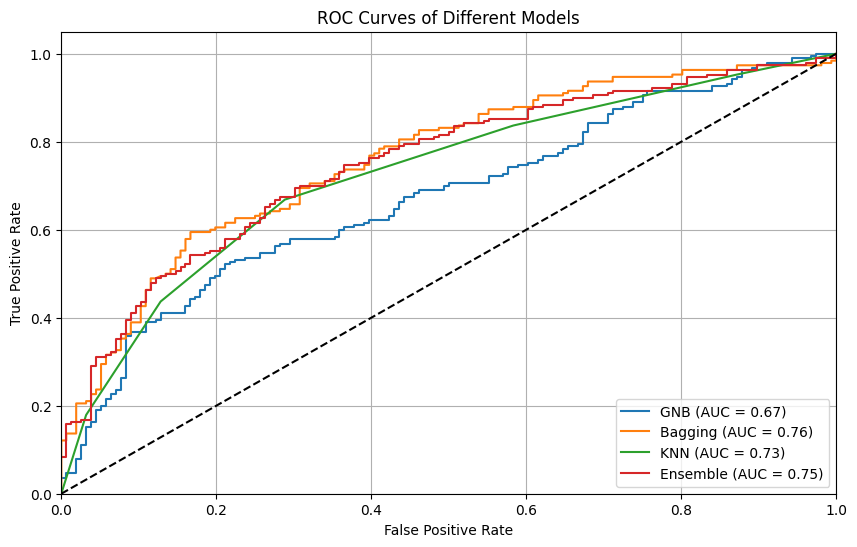

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# 训练集、测试集 ROC曲线图
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制各个模型的ROC曲线
classifiers = {
    'GNB': best_pipe1, 
    'Bagging': best_bagging, 
    'KNN': best_pipe3, 
    'Ensemble': best_voting_clf
}

for clf_name, clf in classifiers.items():
    # 训练模型并获取预测概率
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    # 计算ROC曲线的FPR和TPR
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # 绘制ROC曲线
    ax.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (clf_name, roc_auc))

# 设置图形参数
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves of Different Models')
ax.legend(loc="lower right")
ax.grid(True)
plt.show()



Model: GNB
Precision: 0.718
Recall: 0.537
F1: 0.614
Confusion Matrix:
 [[116  40]
 [ 88 102]]


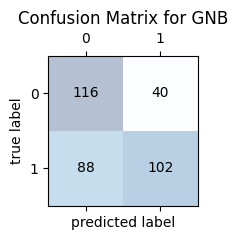

--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model: Bagging
Precision: 0.775
Recall: 0.616
F1: 0.686
Confusion Matrix:
 [[122  34]
 [ 73 117]]


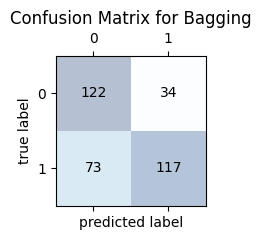

--------------------------------------------------
Model: KNN
Precision: 0.738
Recall: 0.668
F1: 0.702
Confusion Matrix:
 [[111  45]
 [ 63 127]]


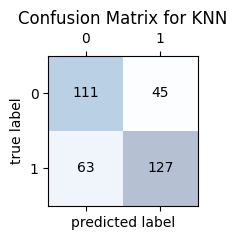

--------------------------------------------------
Model: Ensemble
Precision: 0.759
Recall: 0.579
F1: 0.657
Confusion Matrix:
 [[121  35]
 [ 80 110]]


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


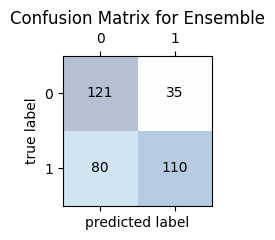

--------------------------------------------------


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# 绘制各个模型的ROC曲线
classifiers = {
    'GNB': best_pipe1, 
    'Bagging': best_bagging, 
    'KNN': best_pipe3, 
    'Ensemble': best_voting_clf
}

for clf_name, clf in classifiers.items():
    # 训练模型并获取预测结果
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    # 计算并输出精度、召回率和F1分数
    print(f'Model: {clf_name}')
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
    print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))
    
    # 计算混淆矩阵并绘制
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion Matrix:\n', confmat)
    
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.title(f'Confusion Matrix for {clf_name}')

    plt.tight_layout()
    plt.show()

    print('-' * 50)
